In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-tot_chl_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
print result.columns

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)
print sds.columns


Index([u'tot_chl', u'Cruise', u'Day', u'File_Id'], dtype='object')
Index([u'Day', u'LAT', u'LON', u'File_Id', u'T', u'S', u'Cruise'], dtype='object')


In [3]:
# join sds dataframe to opp file averages

print sds.shape
#print type(sds), type(cIdx[9])
#new_table = pd.merge(sds, result, how="inner")
new_table = pd.merge(sds, result, how="inner")


#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['tot_chl']].values 

(69235, 7)


In [4]:
# identify continuous transects
# start by just picking out cruises that we know fit the bill

# look at how the clusters relate to physical properties of the water column...

cr = 'Thompson_1'
crsub = new_table[(new_table['Cruise']==cr)].sort(['Day','File_Id'],ascending=[1,1])
crsub['density'] = sw.rho(crsub['S'].values,crsub['T'].values,0)

cxx = (crsub['LON']).values # longitude
cyy = (crsub['LAT']).values # latitude

# convert all longitude to longitude east
cxx[cxx<0]= 360+cxx[cxx<0];
cxbew = cxx
cxbew[cxbew>180] = cxbew[cxbew>180]-360

# calculate distance between points
cdistance = sw.distance(cxbew,cyy, 0)[0]
ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)


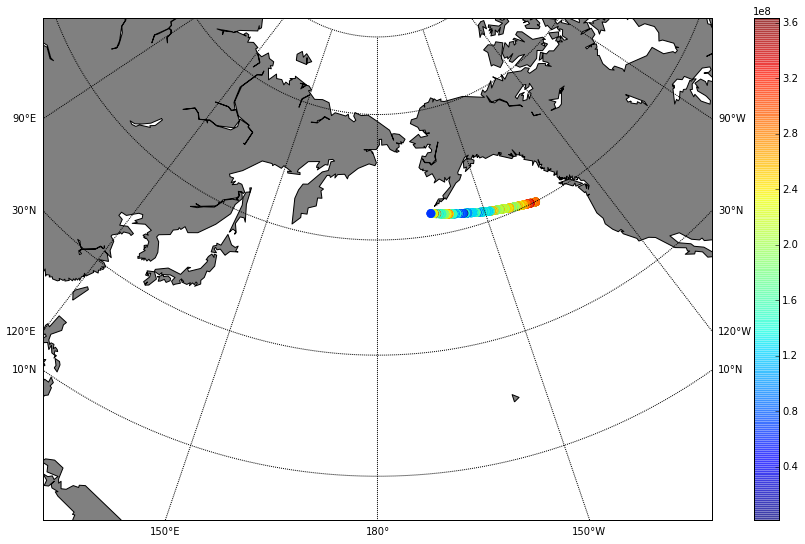

49.9373


53.747197

In [5]:
# plot the cruise track

fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(cxbew,cyy)
m.scatter(xm, ym, s=75, c=crsub['tot_chl'], alpha=.5,lw=0)

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])


plt.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar()
plt.show()

print cyy.min(); cyy.max()

In [6]:
# "continuous" tracks of data are found between 63:950 952:1015 1017:1371
# now turn these into 3 separate datasets, track1, track2 and track3
# check the lemgth of these tracks

t1 = ctrack[950]-ctrack[63] #1174km long
t2 = ctrack[1015]-ctrack[952] #108km long, this track is short and a bit dodgy
t3 = ctrack[1371]-ctrack[1017] #458km long

# split the subset into tracks
t1sub = crsub.iloc[63:950]
t2sub = crsub.iloc[952:1015]
t3sub = crsub.iloc[1017:1371]

# split the tracks
t1track = ctrack[63:950]-ctrack[63]
t2track = ctrack[952:1015]-ctrack[952]
t3track = ctrack[1017:1371]-ctrack[1017]


# check the effective resolution for the tracks
print cdistance[63:950].mean()/1000, cdistance[63:950].std()/1000
print cdistance[952:1015].mean()/1000, cdistance[952:1015].std()/1000
print cdistance[1017:1371].mean()/1000, cdistance[1017:1371].std()/1000


1.32373622803 0.827037017836
1.71442449262 1.82330681139
1.29587331212 1.0506613335


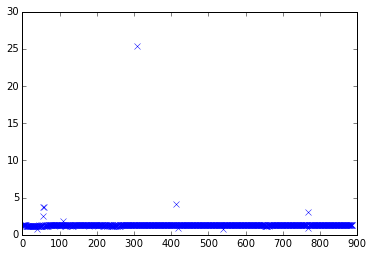

In [7]:
plt.plot(cdistance[63:950]/1000,'x')
plt.show()

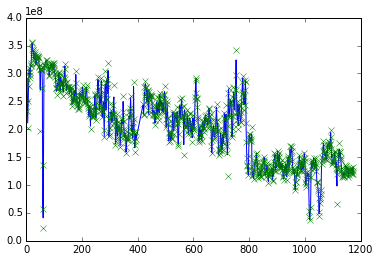

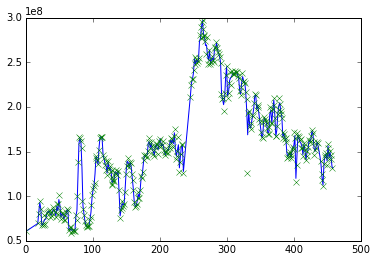

In [8]:
# interpolate the tracks onto a regular n km grid
# set the interpolation scale, n
n = 1.5

t1x = np.arange(0,t1+1000, n*1000)
t3x = np.arange(0,t3+1000, n*1000)
t1int = np.interp(t1x,t1track,t1sub['tot_chl'].values)
t3int = np.interp(t3x,t3track,t3sub['tot_chl'].values)

t1intT = np.interp(t1x,t1track,t1sub['T'].values)
t3intT = np.interp(t3x,t3track,t3sub['T'].values)

plt.plot(t1x/1000,t1int,t1track/1000,t1sub['tot_chl'].values,'x')
plt.show()

plt.plot(t3x/1000,t3int,t3track/1000,t3sub['tot_chl'].values,'x')
plt.show()

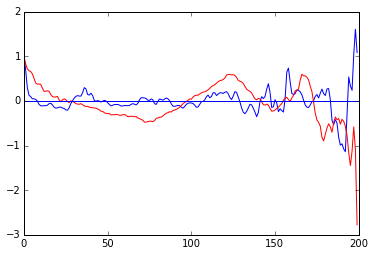

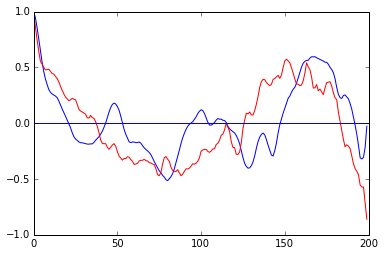

In [9]:
# grab subsets of each track, detrend them and do autocorrelation to get decorrelation length scale
# track 1

#plt.plot(t1x[0:100]/1000,detrend(t1int[0:100], order=1))
#plt.show()

#plt.plot(t3x[0:100]/1000,detrend(t3int[0:100], order=1))
#plt.show()
plt.hold(True)
plt.plot(acf(detrend(t1int[0:200], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t1intT[0:200], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()

plt.hold(True)
plt.plot(acf(detrend(t3int[0:200], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t3intT[0:200], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()



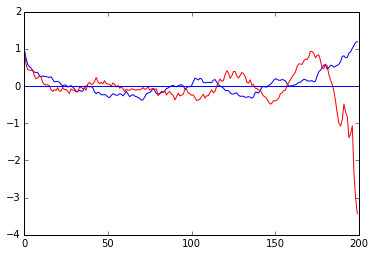

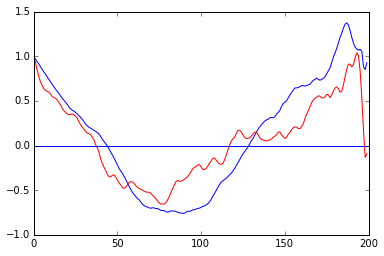

In [10]:
# grab subsets of each track, detrend them and do autocorrelation to get decorrelation length scale
# track 1

#plt.plot(t1x[0:100]/1000,detrend(t1int[0:100], order=1))
#plt.show()

#plt.plot(t3x[0:100]/1000,detrend(t3int[0:100], order=1))
#plt.show()
plt.hold(True)
plt.plot(acf(detrend(t1int[100:300], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t1intT[100:300], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()

plt.hold(True)
plt.plot(acf(detrend(t3int[100:300], order=1), unbiased =True, nlags = 200),'b')
plt.plot(acf(detrend(t3intT[100:300], order=1), unbiased =True, nlags = 200),'r')
plt.axhline()
plt.show()



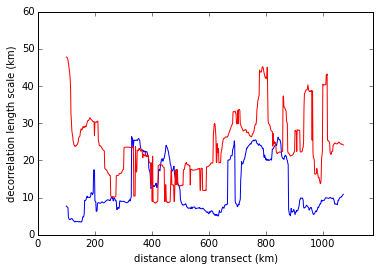

In [19]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t1int
data_inT = t1intT
x_in = t1x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros(lf/n)
decorr_l = np.zeros(lf/n)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf = acf(detrend(data,order=1),unbiased =True, nlags = ll/n)
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind]))*n)
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf = acf(detrend(dataT,order=1),unbiased =True, nlags = ll/n)
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n
    
decorr_l1 = decorr_l
decorr_lT1 = decorr_lT
decorr_track1 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
plt.hold(True)
plt.plot(decorr_track1,decorr_l1,'b')
plt.plot(decorr_track1,decorr_lT1,'r')
plt.xlim([0, np.max(x_in)/1000])
plt.ylim([0,60])
plt.xlabel('distance along transect (km)')
plt.ylabel('decorrelation length scale (km)')
plt.show()

(172, 3)


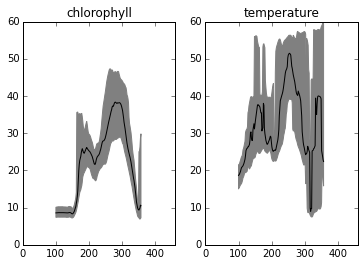

In [56]:
# now try to sequentially detrend and calculate acf for a moving window of data
# this should be done over a window of at least 200km (or close to the eddy variability wavelength)

# pick the track to analyse
data_in = t3int
data_inT = t3intT
x_in = t3x

ll = 200 # length of segment
lf = np.int(np.floor((np.max(x_in)/1000)-ll)) # last possible start point for a segment

decorr_lT = np.zeros((lf/n,3))
decorr_l = np.zeros((lf/n,3))
print np.shape(decorr_l)

for t in range(np.int(lf/n)):
    data = data_in[t:t+(ll/n)]
    tr_acf, tr_conf = acf(detrend(data,order=1),unbiased =True, nlags = (ll/n)-1, alpha = 0.5)
    
    # find first zero crossing for decorrelation length scale
    zero_crossings = np.where(np.diff(np.sign(tr_acf)))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t,0] = (dc_ind + ((0-tr_acf[dc_ind])/(tr_acf[dc_ind+1]-tr_acf[dc_ind])))*n
    
    # find first zero crossing for lower confidence bound
    zero_crossings = np.where(np.diff(np.sign(tr_conf[:,0])))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t,1] = (dc_ind + ((0-tr_conf[dc_ind,0])/(tr_conf[dc_ind+1,0]-tr_conf[dc_ind,0])))*n
    
    # find first zero crossing for upper confidence bound
    zero_crossings = np.where(np.diff(np.sign(tr_conf[:,1])))[0]
    dc_ind = zero_crossings[0]
    decorr_l[t,2] = (dc_ind + ((0-tr_conf[dc_ind,1])/(tr_conf[dc_ind+1,1]-tr_conf[dc_ind,1])))*n
    
    dataT = data_inT[t:t+(ll/n)]
    trT_acf, trT_conf = acf(detrend(dataT,order=1),unbiased =True, nlags = (ll/n)-1, alpha=0.5)
    
    zero_crossingsT = np.where(np.diff(np.sign(trT_acf)))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t,0] = (dc_indT + ((0-trT_acf[dc_indT])/(trT_acf[dc_indT+1]-trT_acf[dc_indT])))*n
    
    zero_crossingsT = np.where(np.diff(np.sign(trT_conf)[:,0]))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t,1] = (dc_indT + ((0-trT_conf[dc_indT,0])/(trT_conf[dc_indT+1,0]-trT_conf[dc_indT,0])))*n
    
    zero_crossingsT = np.where(np.diff(np.sign(trT_conf[:,1])))[0]
    dc_indT = zero_crossingsT[0]
    decorr_lT[t,2] = (dc_indT + ((0-trT_conf[dc_indT,1])/(trT_conf[dc_indT+1,1]-trT_conf[dc_indT,1])))*n

    
decorr_l3 = decorr_l
decorr_lT3 = decorr_lT
decorr_track3 = np.arange(np.int(ll/2),np.int(lf+ll/2)-1,n)
    
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True)

ax1.plot(decorr_track3,decorr_l3[:,0],'k')
ax1.fill_between(decorr_track3, decorr_l3[:,1], decorr_l3[:,2], color='grey')
ax1.set_xlim([0, np.max(x_in)/1000])
ax1.set_ylim([0,60])
#plt.ylabel('decorrelation length scale (km)')
#plt.xlabel('distance along transect (km)')
ax2.plot(decorr_track3,decorr_lT3[:,0],'k')
ax2.fill_between(decorr_track3, decorr_lT3[:,1], decorr_lT3[:,2],color = 'grey')
ax2.set_xlim([0, np.max(x_in)/1000])
ax2.set_ylim([0,60])
ax2.set_title('temperature')
ax1.set_title('chlorophyll')


plt.show()

In [ ]:
# play around with output from acf

a, c = acf(detrend(t1int[0:201], order=1), unbiased =True, nlags = 200, alpha = 0.5)

plt.plot(range(len(a)), a)
plt.fill_between(range(len(a)),c[:,0],c[:,1])
plt.show()

In [ ]:
# put the decorrelation length scales back onto a single track